<a href="https://colab.research.google.com/github/gmenendez0/7506R-2C2023-GRUPO07/blob/main/TP2/Modelos/RedesNeuronalesTP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import joblib

#modelos y métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_text

import nltk
from nltk import tokenize
# Descargamos las stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Importamos el interfaz SnowballStemmer que tiene versión en Español para las derivaciones de palabras
from nltk.stem import SnowballStemmer

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MaxAbsScaler
import scipy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
dsTrain = pd.read_csv('train.csv')
dsTest = pd.read_csv('test.csv')
dsTrainCopy = dsTrain.copy()
dsTestCopy = dsTest.copy()

In [3]:
dsTest = pd.read_csv('test.csv')

# Preprocesamiento

Hacemos que el setimiento sea 1 si es positivo y 0 si es negativo para poder correr los modelos, ademas cambiamos el label de 'sentimiento' a 'label'

In [4]:
dsTrainCopy['label'] = (dsTrainCopy['sentimiento']=='positivo').astype(int)
dsTrainCopy.drop('sentimiento', axis=1, inplace=True)
dsTrainCopy.head()


,ID,review_es,label
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1
3,3,"Básicamente, hay una familia donde un niño peq...",0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


Mostramos los stopwords que hay en ingles

In [5]:
stop_words_sp = set(stopwords.words('english'))
print(stop_words_sp)

{'against', "mightn't", 'myself', 'yourselves', 'd', 'below', "you'll", 'and', 'because', 'or', 'before', 'if', 'this', "shouldn't", 'these', 'do', 'having', 'needn', "she's", 'nor', 'hers', 'should', 'only', 'theirs', 'who', 'all', 'both', 'other', 'had', 'again', 'wouldn', 'y', 'she', 'of', "hadn't", 'each', "that'll", 'ours', 'now', "mustn't", "you've", 'will', 't', 're', 'from', 'too', 'by', 'over', 'while', 'above', 'during', "should've", 'the', 'mustn', 'which', 'me', 'those', 'some', 'doesn', 'can', 'few', 'we', 'o', 'into', "wouldn't", 'i', 's', 'was', 'there', 'more', "haven't", 'mightn', "won't", 'in', 'with', 'so', 'won', 'not', 'haven', 'a', 'weren', "aren't", 'down', 'be', 'until', 'our', 'ma', 'just', 'is', 'ourselves', 'were', 'hadn', 'them', "don't", "couldn't", 'himself', 'themselves', 'why', 'when', 'shouldn', "you'd", 'wasn', 'yourself', 'does', 'their', 'most', 'his', 'at', 'her', 'they', 'have', 'after', 'further', 'through', 'an', 've', 'doing', 'aren', 'shan', 'a

Mostramos los stopwords que hay en español

In [6]:
stop_words_sp = set(stopwords.words('spanish'))
print(stop_words_sp)

{'hubieron', 'habíamos', 'vuestro', 'sobre', 'estoy', 'tenido', 'cual', 'estuvieras', 'sentid', 'algunas', 'tendré', 'y', 'al', 'todos', 'siente', 'mi', 'estuviste', 'hay', 'fueseis', 'tuvimos', 'nosotras', 'tendremos', 'este', 'estado', 'estuvieran', 'sentidos', 'e', 'fueras', 'me', 'mis', 'estén', 'estaba', 'será', 'ese', 'se', 'habidas', 'como', 'estarías', 'fui', 'tenías', 'fuerais', 'habrían', 'había', 'somos', 'un', 'estad', 'eso', 'algunos', 'han', 'hayan', 'son', 'tendría', 'entre', 'donde', 'sean', 'esos', 'sí', 'seamos', 'era', 'fueron', 'habido', 'que', 'fueses', 'ella', 'habida', 'seremos', 'teniendo', 'tuyo', 'ni', 'estáis', 'tienen', 'uno', 'están', 'éramos', 'tiene', 'hubierais', 'eran', 'suyas', 'tenidas', 'mucho', 'con', 'tenga', 'estuviera', 'hubiéramos', 'estuvieseis', 'estás', 'estuvo', 'estabas', 'os', 'de', 'fuesen', 'está', 'estarían', 'fuese', 'algo', 'habían', 'tuyos', 'nuestras', 'sus', 'seréis', 'estuve', 'esto', 'poco', 'tenía', 'vuestra', 'por', 'serían', '

Hay varias palabras en español que tienen acentos, por ende se los vamos a sacar

In [7]:
import re
def quitar_acentos(texto):
    reemplazar = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in reemplazar:
        texto = texto.replace(a, b).replace(a.upper(), b.upper())
    return texto

stemmer = SnowballStemmer("spanish")
def tokenize(text):
    text = re.sub('[^a-z0-9ñ ]', '', text)
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

# Vectorizacion

In [8]:
vecTrain = TfidfVectorizer()
vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out().size

175853

In [9]:
vecTest = TfidfVectorizer()
vecTest.fit_transform(dsTestCopy.review_es)
vecTest.get_feature_names_out().size

57358

Dado que hay mucha cantidad de features, vamos a buscar reducir la cantidad de manera de no consumir mucho recursos computacionales

## Features 1000

In [10]:
vecTrain = TfidfVectorizer(max_features = 1000)
vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out()

array(['10', '20', '30', '70', '80', '90', 'about', 'absolutamente',
       'absoluto', 'aburrida', 'aburrido', 'acción', 'acerca', 'actor',
       'actores', 'actriz', 'actuaciones', 'actuación', 'actuando',
       'actuar', 'acuerdo', 'además', 'adolescente', 'adolescentes',
       'after', 'agradable', 'agua', 'ahora', 'ahí', 'al', 'algo',
       'alguien', 'alguna', 'algunas', 'algunos', 'algún', 'all', 'allá',
       'allí', 'alrededor', 'also', 'alta', 'alto', 'ambos', 'amigo',
       'amigos', 'amor', 'an', 'and', 'animación', 'anterior', 'antes',
       'aparece', 'aparentemente', 'aparte', 'apenas', 'apertura',
       'apoyo', 'aproximadamente', 'aquellos', 'aquí', 'are', 'arte',
       'as', 'asesinato', 'asesino', 'aspecto', 'así', 'at', 'atención',
       'audiencia', 'aunque', 'ayuda', 'año', 'años', 'aún', 'bad',
       'baile', 'bajo', 'banda', 'bastante', 'basura', 'be', 'because',
       'been', 'belleza', 'bien', 'blanco', 'brillante', 'broma', 'buen',
       'buena',

In [11]:
vecTrain.get_feature_names_out().size

1000

* Hay varias stop_words tanto en español como en ingles que sabemos que no tienen mucho valor,
* Hay muchas palabras con tilde, esto puede hacer que en algunos casos en el que se llegue a escribir sin tilde no se considere ese features
* Hay palabras "repetidas" por ejemplo 'trabajar', 'trabajo' estas dos palabras deberian tener el mismo valor. Esto se puede llegar a arreglar mediante stemming(cortar palabras) o lemmatization(buscar la palabra origen)



In [12]:
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [quitar_acentos(word) for word in stop_words]
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
vecTrain = TfidfVectorizer(max_features = 1000, stop_words=stop_words, strip_accents="unicode")
X = vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out()

array(['10', '100', '15', '20', '30', '50', '70', '80', '90',
       'absolutamente', 'absoluto', 'aburrida', 'aburrido', 'acaba',
       'acabo', 'accidente', 'accion', 'acerca', 'actor', 'actores',
       'actriz', 'actuacion', 'actuaciones', 'actuando', 'actuar',
       'acuerdo', 'adelante', 'ademas', 'adolescente', 'adolescentes',
       'adultos', 'agradable', 'agua', 'ahi', 'ahora', 'aire', 'alguien',
       'algun', 'alguna', 'alla', 'alli', 'alrededor', 'also', 'alta',
       'altamente', 'alto', 'ambos', 'america', 'amigo', 'amigos', 'amo',
       'amor', 'animacion', 'animales', 'ano', 'anos', 'anterior',
       'anteriores', 'antigua', 'antiguo', 'aparece', 'aparentemente',
       'aparte', 'apenas', 'apertura', 'apoyo', 'aproximadamente',
       'aquellos', 'aqui', 'armas', 'arte', 'asesinato', 'asesino', 'asi',
       'aspecto', 'aspectos', 'asunto', 'atencion', 'audiencia', 'aun',
       'aunque', 'auto', 'automovil', 'ayuda', 'bad', 'baile', 'baja',
       'bajo', 'band

## Stemmer

Vamos a utilizar un stemmer porque es mas rapido aunque no necesariamente sea lo mejor porque al cortarlas dos palabras con el mismo significado pueden seguir siendo distintas

In [14]:
stemmer = SnowballStemmer("spanish")
def tokenize(text):
    text = re.sub('[^a-z0-9ñ ]', '', text) #aplico esto para evitar que el stemmer tome cosas como ¿hol
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

In [15]:
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [quitar_acentos(word) for word in stop_words]
vecTrain = TfidfVectorizer(max_features = 1000,tokenizer=tokenize, stop_words=stop_words, strip_accents="unicode")
X = vecTrain.fit_transform(dsTrainCopy.review_es)
vecTrain.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'algun', 'arent', 'becaus', 'befor', 'betw', 'com', 'contr', 'couldnt', 'cuand', 'desd', 'didnt', 'doesnt', 'dond', 'dont', 'durant', 'eram', 'estab', 'estam', 'estand', 'estari', 'estem', 'estuv', 'estuvier', 'estuvies', 'fuer', 'fues', 'fuim', 'fuist', 'furth', 'hab', 'habi', 'habr', 'habri', 'hadnt', 'hasnt', 'hast', 'hav', 'havent', 'hem', 'hub', 'hubier', 'hubies', 'isnt', 'mightnt', 'mor', 'much', 'mustnt', 'nad', 'neednt', 'nosotr', 'nuestr', 'ourselv', 'par', 'per', 'poc', 'porqu', 'qui', 'sam', 'seam', 'sent', 'ser', 'seri', 'shant', 'shes', 'shouldnt', 'shouldv', 'sient', 'sint', 'sobr', '

array(['1', '10', '12', '2', '20', '3', '30', '4', '5', '70', '80', '90',
       'abandon', 'abiert', 'absolut', 'aburr', 'acab', 'accion', 'acent',
       'acept', 'acerc', 'actor', 'actriz', 'actu', 'actuacion', 'actual',
       'acuerd', 'adapt', 'adecu', 'adem', 'admit', 'adolescent', 'adult',
       'afirm', 'agrad', 'agreg', 'agu', 'ahi', 'ahor', 'air', 'ajust',
       'alegr', 'alej', 'algui', 'algun', 'alla', 'alli', 'alquil',
       'alrededor', 'also', 'alta', 'alto', 'amant', 'ambos', 'amenaz',
       'amer', 'amig', 'amor', 'angel', 'anim', 'animal', 'ano', 'anos',
       'anterior', 'antigu', 'apag', 'aparec', 'aparent', 'apart', 'apen',
       'apertur', 'apoy', 'apreci', 'aprend', 'aproxim', 'aquell', 'aqui',
       'arrastr', 'arte', 'artist', 'asesin', 'asesinat', 'asi', 'aspect',
       'asunt', 'asust', 'atencion', 'aterr', 'atmosfer', 'atract',
       'atrap', 'audienci', 'aun', 'aunqu', 'automovil', 'aventur',
       'ayud', 'b', 'bad', 'bail', 'baj', 'band', 'bara

No podemos vectorizar dejanado todos los features ya que no nos alcanza la cantidad de RAM, entonces a partir de esto hicimos unas pruebas para determinar cual es la mejor cantidad de features. Pero resumiendo cuando probamos los modelos con 1000 features, los resultados fueron mejores en Kaggle probablemente porque overfiteamos menos con menor cantidad de features

# Conjuntos de entrenamiento

In [16]:
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [quitar_acentos(word) for word in stop_words]
vecTrain = TfidfVectorizer(max_features = 1000,tokenizer=tokenize, stop_words=stop_words, strip_accents="unicode")
X = vecTrain.fit_transform(dsTrainCopy.review_es)
X = X.toarray()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,dsTrainCopy.label,test_size=0.2,random_state=25,shuffle=True,stratify=dsTrainCopy.label)
#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(X_train)))
print('# Datos Prueba: {}'.format(len(X_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))


# Datos Entrenamiento: 40000
# Datos Prueba: 10000
% Positivos Entrenamiento: 50.000
% Positivos Prueba: 50.000


In [18]:
def metricas(y_pred,y_test):
  print("El accuracy es: {}\n".format(accuracy_score(y_test,y_pred)))
  print("El f1 es: {}\n".format(f1_score(y_test,y_pred)))
  print("El recall es: {}\n".format(recall_score(y_test,y_pred)))
  print("La precision es: {}\n\n".format(precision_score(y_test,y_pred)))
  print(classification_report(y_test,y_pred))

In [19]:
def resultados(model,umbral=0.4):
  y_pred = model.predict(X_test)
  y_pred = np.where(y_pred>umbral,1,0)
  metricas(y_test,y_pred)
  ds_validacion=pd.DataFrame(y_pred,y_test).reset_index()
  ds_validacion.columns=['y_pred','y_real']

  tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
  rf=sns.heatmap(tabla,annot=True, cmap = 'Blues')

In [ ]:
def print_grid_results(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Redes Neuronales

Red simples

In [ ]:
d_in = X_train.shape[1]
modelo= keras.Sequential([
keras.layers.Dense(500,input_shape=(d_in,), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red = modelo.fit(X_train,y_train,verbose=False)

313/313 [==============================] - 1s 3ms/step
El accuracy es: 0.8289

El f1 es: 0.8417645426801071

El recall es: 0.782900395664889

La precision es: 0.9102


              precision    recall  f1-score   support

           0       0.75      0.89      0.81      4187
           1       0.91      0.78      0.84      5813

    accuracy                           0.83     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.84      0.83      0.83     10000



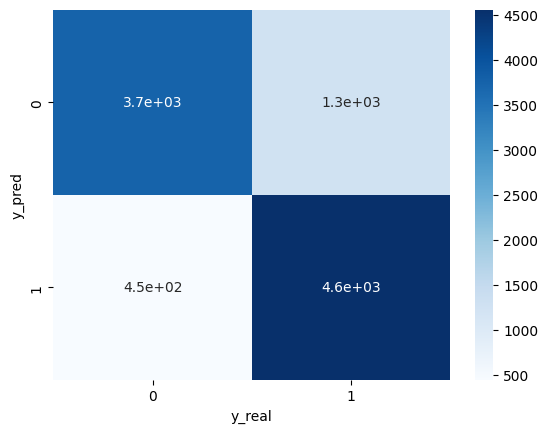

In [ ]:
resultados(modelo)

# Red Neuronal Grid

In [ ]:
d_in = X_train.shape[1]
def create_model():
    modelo= keras.Sequential([
    keras.layers.Dense((d_in/2),input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

    modelo.compile(
      optimizer="adam",
      loss='binary_crossentropy',
      # metricas para ir calculando en cada iteracion o batch
      metrics=['accuracy'],
    )

    return modelo

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier

In [ ]:
param_grid = {
    'epochs': [20],
    'batch_size' : [16,32,64],
    'callbacks' : [tf.keras.callbacks.EarlyStopping("accuracy",patience=5)]
}

print(param_grid)
modelo_cv = KerasClassifier(build_fn=create_model)
grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid,n_jobs=-1,cv=4)
grid_result = grid.fit(X_train, y_train)

{'epochs': [20], 'batch_size': [16, 32, 64], 'callbacks': [<keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>]}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
625/625 [==============================] - 8s 11ms/step - loss: 0.3902 - accuracy: 0.8265
Epoch 2/20
625/625 [==============================] - 8s 13ms/step - loss: 0.3453 - accuracy: 0.8443
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3341 - accuracy: 0.8492
Epoch 4/20
625/625 [==============================] - 8s 12ms/step - loss: 0.3192 - accuracy: 0.8589
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.2971 - accuracy: 0.8718
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 0.2668 - accuracy: 0.8899
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2267 - accuracy: 0.9139
Epoch 8/20
625/625 [==============================] - 7s 11ms/step - loss: 0.1790 - accuracy: 0.9419
Epoch 9/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1285 - accuracy: 0.9675
Epoch 10/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0836 - accura

Podemos ver que a partir de 10 epochs la red empieza a overfittear

In [ ]:
print_grid_results(grid_result)

Best: 0.844575 using {'batch_size': 64, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}
0.841375 (0.001998) with: {'batch_size': 16, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}
0.843975 (0.002063) with: {'batch_size': 32, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}
0.844575 (0.002720) with: {'batch_size': 64, 'callbacks': <keras.src.callbacks.EarlyStopping object at 0x7b671e7ce2f0>, 'epochs': 20}


In [ ]:
best_estimator = grid_result.best_estimator_

157/157 [==============================] - 2s 9ms/step
El accuracy es: 0.8492

El f1 es: 0.8513406940063091

El recall es: 0.8394245723172629

La precision es: 0.8636


              precision    recall  f1-score   support

           0       0.83      0.86      0.85      4856
           1       0.86      0.84      0.85      5144

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



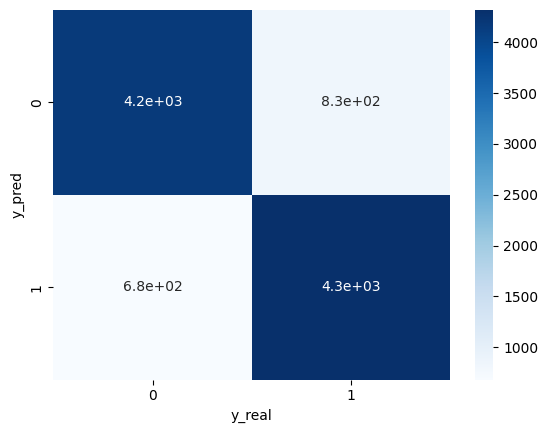

In [ ]:
resultados(best_estimator)

In [ ]:
joblib.dump(best_estimator, 'red_grid.joblib')

['red_grid.joblib']

# Red Neuronal 1

In [ ]:
d_in = X_train.shape[1]
modelo1= keras.Sequential([
keras.layers.Dense(d_in,input_shape=(d_in,), activation='relu'),
keras.layers.Dropout(0.2),
keras.layers.Dense(1, activation='sigmoid')])

modelo1.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo1.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 20s 15ms/step - loss: 0.3903 - accuracy: 0.8253
Epoch 2/10
1250/1250 [==============================] - 33s 26ms/step - loss: 0.3447 - accuracy: 0.8476
Epoch 3/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.3290 - accuracy: 0.8533
Epoch 4/10
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3094 - accuracy: 0.8655
Epoch 5/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.2844 - accuracy: 0.8825
Epoch 6/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2496 - accuracy: 0.9037
Epoch 7/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.2067 - accuracy: 0.9278
Epoch 8/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.1587 - accuracy: 0.9517
Epoch 9/10
1250/1250 [==============================] - 24s 20ms/step - loss: 0.1113 - accuracy: 0.9714
Epoch 10/10
1250/1250 [==============================] - 18s 14m

313/313 [==============================] - 1s 4ms/step
El accuracy es: 0.8402

El f1 es: 0.8465232424126009

El recall es: 0.8143015521064302

La precision es: 0.8814


              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4588
           1       0.88      0.81      0.85      5412

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



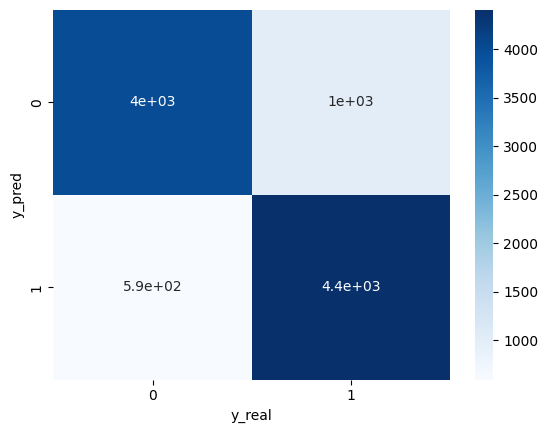

In [ ]:
resultados(modelo1)

In [ ]:
joblib.dump(modelo1, 'red_grid1.joblib')

['red_grid1.joblib']

# Red Neuronal 2

In [ ]:
d_in = X_train.shape[1]
modelo2= keras.Sequential([
keras.layers.Dense(d_in,input_shape=(d_in,), activation='relu'),
keras.layers.Dropout(0.2),
keras.layers.Dense(1, activation='sigmoid')])

modelo2.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo2.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 25s 17ms/step - loss: 0.3908 - accuracy: 0.8247
Epoch 2/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3444 - accuracy: 0.8463
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3283 - accuracy: 0.8548
Epoch 4/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3080 - accuracy: 0.8658
Epoch 5/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2815 - accuracy: 0.8847
Epoch 6/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.2459 - accuracy: 0.9068
Epoch 7/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2019 - accuracy: 0.9312
Epoch 8/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.1542 - accuracy: 0.9536
Epoch 9/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.1078 - accuracy: 0.9721
Epoch 10/10
1250/1250 [==============================] - 23s 18m

313/313 [==============================] - 2s 5ms/step
El accuracy es: 0.8379

El f1 es: 0.8346761856195819

El recall es: 0.8516129032258064

La precision es: 0.8184


              precision    recall  f1-score   support

           0       0.86      0.83      0.84      5195
           1       0.82      0.85      0.83      4805

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



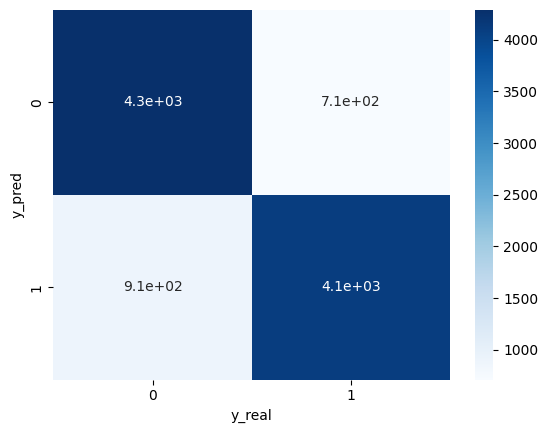

In [ ]:
resultados(modelo2)

In [ ]:
joblib.dump(modelo2, 'red_grid2.joblib')

['red_grid2.joblib']

# Red Neuronal 3

In [ ]:
d_in = X_train.shape[1]
modelo3= keras.Sequential([
keras.layers.Dropout(0.2, input_shape=(d_in,)),
keras.layers.Dense(d_in, activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo3.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo3.fit(X_train,y_train,epochs=10)

Epoch 1/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4224 - accuracy: 0.8077
Epoch 2/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3794 - accuracy: 0.8259
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3736 - accuracy: 0.8287
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3570 - accuracy: 0.8403
Epoch 5/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3446 - accuracy: 0.8487
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3275 - accuracy: 0.8587
Epoch 7/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3055 - accuracy: 0.8734
Epoch 8/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.2842 - accuracy: 0.8874
Epoch 9/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.2593 - accuracy: 0.9019
Epoch 10/10
1250/1250 [==============================] - 18s 14m

313/313 [==============================] - 2s 5ms/step
El accuracy es: 0.8368

El f1 es: 0.8480446927374303

El recall es: 0.7933797909407666

La precision es: 0.9108


              precision    recall  f1-score   support

           0       0.76      0.90      0.82      4260
           1       0.91      0.79      0.85      5740

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



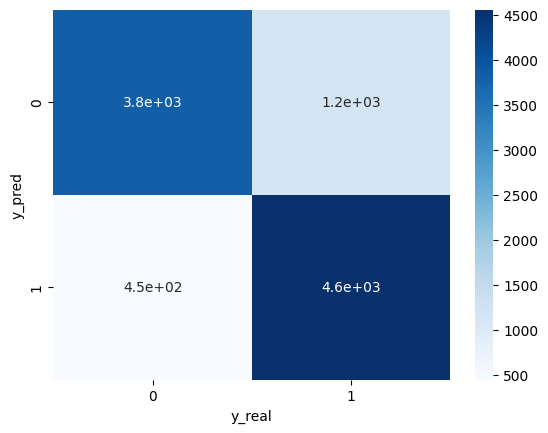

In [ ]:
resultados(modelo3)

In [ ]:
joblib.dump(modelo3, 'red_grid3.joblib')

['red_grid3.joblib']

#Red Neuronal 4

In [ ]:
d_in = X_train.shape[1]
modelo4= keras.Sequential([
keras.layers.Dense(d_in, activation='relu'),
keras.layers.Dense((d_in/2), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo4.compile(
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo4.fit(X_train,y_train,epochs=5)

Epoch 1/5
1250/1250 [==============================] - 26s 20ms/step - loss: 0.3845 - accuracy: 0.8230
Epoch 2/5
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3344 - accuracy: 0.8520
Epoch 3/5
1250/1250 [==============================] - 27s 21ms/step - loss: 0.2922 - accuracy: 0.8765
Epoch 4/5
1250/1250 [==============================] - 25s 20ms/step - loss: 0.2125 - accuracy: 0.9185
Epoch 5/5
1250/1250 [==============================] - 26s 21ms/step - loss: 0.1127 - accuracy: 0.9628


313/313 [==============================] - 2s 6ms/step
El accuracy es: 0.8352

El f1 es: 0.8425978987583572

El recall es: 0.8063985374771481

La precision es: 0.8822


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      4530
           1       0.88      0.81      0.84      5470

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.84     10000



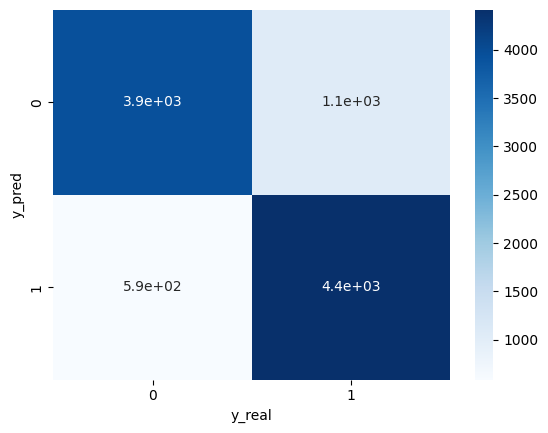

In [ ]:
resultados(modelo4)

In [ ]:
joblib.dump(modelo4, 'red_grid4.joblib')

['red_grid4.joblib']

#Red Neuronal 5

In [20]:
d_in = X_train.shape[1]
modelo5= keras.Sequential([
keras.layers.Dense((d_in/2), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo5.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo5.fit(X_train,y_train,epochs=5)

Epoch 1/5
1250/1250 [==============================] - 14s 11ms/step - loss: 0.3830 - accuracy: 0.8278
Epoch 2/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.3428 - accuracy: 0.8452
Epoch 3/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.3230 - accuracy: 0.8566
Epoch 4/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2893 - accuracy: 0.8772
Epoch 5/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2401 - accuracy: 0.9064


313/313 [==============================] - 1s 3ms/step
El accuracy es: 0.8402

El f1 es: 0.8462574562247451

El recall es: 0.8153503893214683

La precision es: 0.8796


              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4606
           1       0.88      0.82      0.85      5394

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



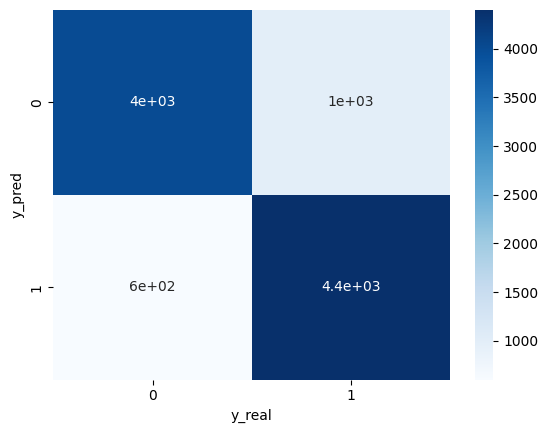

In [21]:
resultados(modelo5)

In [22]:
joblib.dump(modelo5, 'red_grid5.joblib')

['red_grid5.joblib']

Subimos el umbral

313/313 [==============================] - 1s 4ms/step
El accuracy es: 0.8456

El f1 es: 0.848151062155783

El recall es: 0.8343653250773994

La precision es: 0.8624


              precision    recall  f1-score   support

           0       0.83      0.86      0.84      4832
           1       0.86      0.83      0.85      5168

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



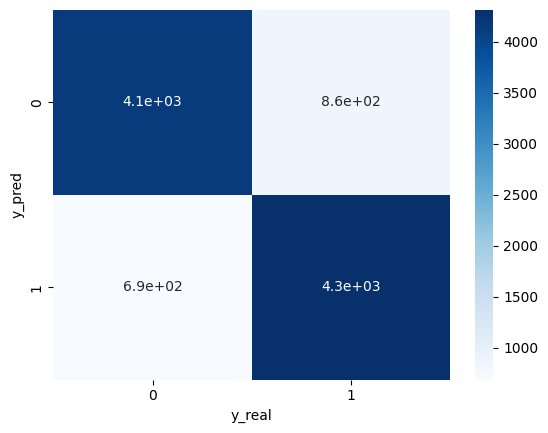

In [23]:
resultados(modelo5,0.45)

313/313 [==============================] - 1s 3ms/step
El accuracy es: 0.8444

El f1 es: 0.8438378161380972

El recall es: 0.846897663174859

La precision es: 0.8408


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5036
           1       0.84      0.85      0.84      4964

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



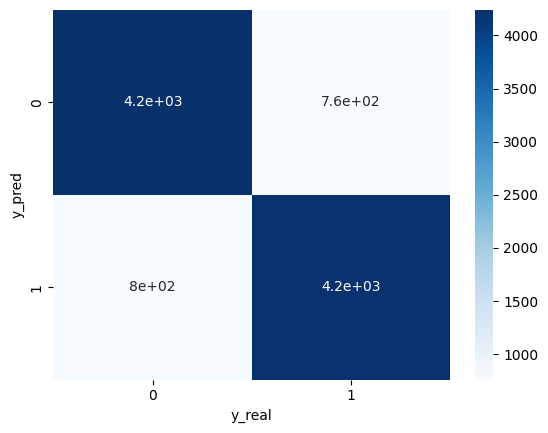

In [24]:
resultados(modelo5,0.5)

In [25]:
joblib.dump(modelo5, 'red_final.joblib')

['red_final.joblib']

# Submission 1

In [ ]:
modelo = joblib.load('red_grid.joblib')

red=modelo.fit(X_train,y_train, epochs=10)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.3891 - accuracy: 0.8265
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3452 - accuracy: 0.8463
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3343 - accuracy: 0.8500
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3191 - accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2979 - accuracy: 0.8713
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2679 - accuracy: 0.8897
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2285 - accuracy: 0.9139
Epoch 8/10
625/625 [==============================] - 8s 13ms/step - loss: 0.1790 - accuracy: 0.9413
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1273 - accuracy: 0.9673
Epoch 10/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0824 - accura

In [ ]:
X_TEST = vecTest.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [ ]:
X_TEST = vecTest.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [ ]:
y_pred = modelo.predict(X_TEST)
y_pred

269/269 [==============================] - 1s 5ms/step


array([[1.7237193e-07],
       [8.9536989e-01],
       [1.0244196e-02],
       ...,
       [3.7590417e-01],
       [1.2459115e-03],
       [5.8843967e-02]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,0
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,0
8597,68597,0


In [ ]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [ ]:
df_submission.to_csv("dsTP2RNSub1.csv",index=False)

# Submission 2

In [ ]:
xDsTrainS2 = X.copy()
yTrainS2 = dsTrainCopy['label']

In [ ]:
d_in = xDsTrainS2.shape[1]
modelo= keras.Sequential([
keras.layers.Dense((d_in/2), activation='relu'),
keras.layers.Dense(1, activation='sigmoid')])

modelo.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['accuracy'],
)

red=modelo.fit(xDsTrainS2,yTrainS2,epochs=5)

Epoch 1/5
1563/1563 [==============================] - 19s 11ms/step - loss: 0.3763 - accuracy: 0.8320
Epoch 2/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.3409 - accuracy: 0.8463
Epoch 3/5
1563/1563 [==============================] - 15s 9ms/step - loss: 0.3194 - accuracy: 0.8593
Epoch 4/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.2838 - accuracy: 0.8816
Epoch 5/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2291 - accuracy: 0.9141


In [ ]:
X_TEST = vecTest.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [ ]:
y_pred = modelo.predict(X_TEST)
y_pred

269/269 [==============================] - 1s 3ms/step


array([[0.02045584],
       [0.49281943],
       [0.02746232],
       ...,
       [0.31019786],
       [0.00700497],
       [0.07141757]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,0
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,0
8597,68597,0


In [ ]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [ ]:
df_submission.to_csv("dsTP2RNSub2.csv",index=False)

# Submission 3



In [ ]:
modelo = joblib.load('red_grid3.joblib')

red=modelo.fit(X_train,y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.0435 - accuracy: 0.9912
Epoch 2/10
1250/1250 [==============================] - 26s 20ms/step - loss: 0.0266 - accuracy: 0.9948
Epoch 3/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.0164 - accuracy: 0.9972
Epoch 4/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0106 - accuracy: 0.9982
Epoch 5/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0072 - accuracy: 0.9988
Epoch 6/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0050 - accuracy: 0.9993
Epoch 7/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.0037 - accuracy: 0.9997
Epoch 8/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 9/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 10/10
1250/1250 [==============================] - 18s 15m

In [ ]:
X_TEST = vecTest.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [ ]:
y_pred = modelo.predict(X_TEST)
y_pred

269/269 [==============================] - 1s 5ms/step


array([[1.11326864e-10],
       [9.87762570e-01],
       [1.23800349e-03],
       ...,
       [9.75058615e-01],
       [1.01716760e-05],
       [4.30465415e-02]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

,id,Sentimiento
0,60000,0
1,60001,1
2,60002,0
3,60003,1
4,60004,0
...,...,...
8594,68594,1
8595,68595,0
8596,68596,1
8597,68597,0


In [ ]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

,id,Sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


In [ ]:
df_submission.to_csv("dsTP2RNSub3.csv",index=False)

#Submission 4

In [27]:
modelo = joblib.load('red_final.joblib')

red=modelo.fit(X_train,y_train, epochs=5)

Epoch 1/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1776 - accuracy: 0.9421
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1129 - accuracy: 0.9721
Epoch 3/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0600 - accuracy: 0.9910
Epoch 4/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0278 - accuracy: 0.9975
Epoch 5/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0127 - accuracy: 0.9995


In [28]:
X_TEST = vecTest.transform(dsTestCopy.review_es)
X_TEST = X_TEST.toarray()

In [29]:
y_pred = modelo.predict(X_TEST)
y_pred

ValueError: ignored

In [ ]:
y_pred = np.where(y_pred>0.45,1,0)
y_pred = y_pred.flatten()
y_pred

In [ ]:
df_submission = pd.DataFrame({'id': dsTestCopy['ID'], 'Sentimiento': y_pred})
df_submission

In [ ]:
df_submission.loc[df_submission['Sentimiento'] == 1, 'Sentimiento'] = 'positivo'
df_submission.loc[df_submission['Sentimiento'] == 0, 'Sentimiento'] = 'negativo'
df_submission

In [ ]:
df_submission.to_csv("dsTP2RNSub4.csv",index=False)